In [0]:
#@title Generate list_data
import json
import ast

def read_from_database():                                       # Take in raw str, and convert to dictionary
        with open("data_list_complete.json") as f:
                content = f.readlines()
        content = [x.strip() for x in content] 
        data = []
        for i in range(0,len(content)):
                data.append(ast.literal_eval(content[i]))       # Converting to dictionary

        data = data[0]                                          # Get database data as dictionary (rather than 1 item list)

        list_companies = data["2019-07-17"].keys()              # Company names
        #list_companies.sort(reverse = False)                    # Sort alphabetically company names
        sorted(list_companies);

        list_days = data.keys()                                # Get Database days
        list_days = sorted(list_days, key = sorting)            # Sort days in past -> future order
                
        bad_companies = ["WLKP", "VMC", "VRS", "REX"]
        bad_days = []

        for day in list(data):
                num_companies = len(data[day])
                for company in list(data["2019-07-17"]):
                        if (company in bad_companies and company in data[day]):
                                del data[day][company]
                        if (num_companies < 161):
                                del data[day]
                                bad_days.append(day)
                                break
        list_companies = list(data["2019-07-17"])
        for company in bad_companies:
            if(company in list_companies):
                list_companies.remove(company)

        for day in bad_days:
                list_days.remove(day)

        # Give AGX data for April 14th (accidentally omitted)
        data["2016-04-14"]["AGX"] = data["2016-04-15"]["AGX"]


        num_days = len(data)
        num_companies = len(data["2016-04-14"])
        num_data_points = len(data["2016-04-14"]["AGX"])


        list_data = [[[0 for i in range(num_data_points)] for j in range(num_companies)] for k in range(num_days)]

        counter_i = 0
        counter_j = 0
        counter_k = 0
        for day in list_days:
                #print(day)
                for company in list_companies:
                        for data_point in range(0,8):
                                list_data[counter_i][counter_j][counter_k] = data[day][company][data_point]
                                counter_k += 1
                        counter_k = 0
                        counter_j += 1
                counter_j = 0
                counter_i += 1
        return list_data

def sorting(L):
        splitup = L.split('-')
        return splitup[0], splitup[1], splitup[2]


# FINAL LIST IS THE VARIABLE: list_data

In [0]:
#@title Normalize Data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data as data
import numpy as np
import random
import math
import json
import ast

# ===========================================================
# ================= Random input generator ==================
# ===========================================================

# 9 input per day       --> dim 1
# 165 companies         --> dim 2
# ~763 days             --> dim 3

def random_input_gen(num_data_per_day = 9, num_companies = 165, num_days = 763): # random numbers ranging from +- 100,000,000,000 (100 billion)
    data = [[[None for k in range(num_data_per_day)] for j in range(num_companies)] for i in range(num_days)]
    for i in range(num_days):
        for j in range(num_companies):
            for k in range(num_data_per_day):
                data[i][j][k] = random.randint(-100000000000,100000000001)
    # Force numbers to ensure logarithmic normalization works
    data[0][0][0] = 15
    data[0][0][1] = 0.05
    return data

# ============================================================
# ===== Formatting data from .json to dictionary to list =====
# ============================================================


# FINAL LIST IS THE VARIABLE: list_data

# ===========================================================
# ====================== Normalization ======================
# ===========================================================

# normalize_function = 0    --> No normalization
# normalize_function = 1    --> linear normalization
# normalize_function = 2    --> logarithmic normalization

# normalize_company = 0     --> normalize inside each company
# normalize_company = 1     --> normalize across all companies

# range = 0                 --> no limit
# range = 1                 --> [-1, 1]
# range = 2                 --> [ 0, 1]

def normalize_data(data, normalize_function = 0, normalize_company = 0, num_range = 0):
    
    if ((num_range != 0 and num_range != 1 and num_range != 2) or (normalize_company != 0 and normalize_company != 1) or (normalize_function != 0 and normalize_function != 1 and normalize_function != 2)):
        print("invalid input")
        return False

    if ((range == 1 or range == 2) and normalize_function == 0):
        print("cannot limit range with no normalization")
        return False
    
    if (range == 0 and normalize_function != 0):
        print("must limit range when normalizing data")
        return False
    
    num_days = len(data)
    num_companies = len(data[0])
    num_data_per_day = len(data[0][0])

    if (normalize_function == 2):      # Take the log 10 of all numbers if we perform logarithmic normalization, else linear do nothing
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    data[j][i][k] = log_normalization(data[j][i][k])
    
    if (normalize_company == 0):
        for i in range(num_companies): # each item is all of format [min, max]
            price, current_ratio, pps, eps, asset_turnover, pe_ratio, cash_flow, return_on_equity, working_capital = [0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (k == 0):
                        if (price[1] < data[j][i][k]):
                            price[1] = data[j][i][k]
                        if (price[0] > data[j][i][k]):
                            price[0] = data[j][i][k]
                    elif (k == 1):
                        if (current_ratio[1] < data[j][i][k]):
                            current_ratio[1] = data[j][i][k]
                        if (current_ratio[0] > data[j][i][k]):
                            current_ratio[0] = data[j][i][k]
                    elif (k == 2):
                        if (pps[1] < data[j][i][k]):
                            pps[1] = data[j][i][k]
                        if (pps[0] > data[j][i][k]):
                            pps[0] = data[j][i][k]
                    elif (k == 3):
                        if (eps[1] < data[j][i][k]):
                            eps[1] = data[j][i][k]
                        if (eps[0] > data[j][i][k]):
                            eps[0] = data[j][i][k]
                    elif (k == 4):
                        if (asset_turnover[1] < data[j][i][k]):
                            asset_turnover[1] = data[j][i][k]
                        if (asset_turnover[0] > data[j][i][k]):
                            asset_turnover[0] = data[j][i][k]
                    elif (k == 5):
                        if (pe_ratio[1] < data[j][i][k]):
                            pe_ratio[1] = data[j][i][k]
                        if (pe_ratio[0] > data[j][i][k]):
                            pe_ratio[0] = data[j][i][k]
                    elif (k == 6):
                        if (cash_flow[1] < data[j][i][k]):
                            cash_flow[1] = data[j][i][k]
                        if (cash_flow[0] > data[j][i][k]):
                            cash_flow[0] = data[j][i][k]
                    elif (k == 7):
                        if (return_on_equity[1] < data[j][i][k]):
                            return_on_equity[1] = data[j][i][k]
                        if (return_on_equity[0] > data[j][i][k]):
                            return_on_equity[0] = data[j][i][k]
                    elif (k == 8):
                        if (working_capital[1] < data[j][i][k]):
                            working_capital[1] = data[j][i][k]
                        if (working_capital[0] > data[j][i][k]):
                            working_capital[0] = data[j][i][k]
            # Normalize within a single company
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (k == 0):
                        data[j][i][k] = (data[j][i][k] - price[0]) / (price[1] - price[0])
                    elif (k == 1):
                        data[j][i][k] = (data[j][i][k] - current_ratio[0]) / (current_ratio[1] - current_ratio[0])
                    elif (k == 2):
                        data[j][i][k] = (data[j][i][k] - pps[0]) / (pps[1] - pps[0])
                    elif (k == 3):
                        data[j][i][k] = (data[j][i][k] - eps[0]) / (eps[1] - eps[0])
                    elif (k == 4):
                        data[j][i][k] = (data[j][i][k] - asset_turnover[0]) / (asset_turnover[1] - asset_turnover[0])
                    elif (k == 5):
                        data[j][i][k] = (data[j][i][k] - pe_ratio[0]) / (asset_turnover[1] - asset_turnover[0])
                    elif (k == 6):
                        if((cash_flow[1]==0)and(cash_flow[0]==0)):
                          cash_flow[1] = 0.05
                        data[j][i][k] = (data[j][i][k] - cash_flow[0]) / (cash_flow[1] - cash_flow[0])
                    elif (k == 7):
                        data[j][i][k] = (data[j][i][k] - return_on_equity[0]) / (return_on_equity[1] - return_on_equity[0])
                    elif (k == 8):
                        data[j][i][k] = (data[j][i][k] - working_capital[0]) / (working_capital[1] - working_capital[0])

    elif (normalize_company == 1):
        price, current_ratio, pps, eps, asset_turnover, pe_ratio, cash_flow, return_on_equity, working_capital = [0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0,0.0]
        for i in range(num_companies): # each item is all of format [min, max]
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (k == 0):
                        if (price[1] < data[j][i][k]):
                            price[1] = data[j][i][k]
                        if (price[0] > data[j][i][k]):
                            price[0] = data[j][i][k]
                    elif (k == 1):
                        if (current_ratio[1] < data[j][i][k]):
                            current_ratio[1] = data[j][i][k]
                        if (current_ratio[0] > data[j][i][k]):
                            current_ratio[0] = data[j][i][k]
                    elif (k == 2):
                        if (pps[1] < data[j][i][k]):
                            pps[1] = data[j][i][k]
                        if (pps[0] > data[j][i][k]):
                            pps[0] = data[j][i][k]
                    elif (k == 3):
                        if (eps[1] < data[j][i][k]):
                            eps[1] = data[j][i][k]
                        if (eps[0] > data[j][i][k]):
                            eps[0] = data[j][i][k]
                    elif (k == 4):
                        if (asset_turnover[1] < data[j][i][k]):
                            asset_turnover[1] = data[j][i][k]
                        if (asset_turnover[0] > data[j][i][k]):
                            asset_turnover[0] = data[j][i][k]
                    elif (k == 5):
                        if (pe_ratio[1] < data[j][i][k]):
                            pe_ratio[1] = data[j][i][k]
                        if (pe_ratio[0] > data[j][i][k]):
                            pe_ratio[0] = data[j][i][k]
                    elif (k == 6):
                        if (cash_flow[1] < data[j][i][k]):
                            cash_flow[1] = data[j][i][k]
                        if (cash_flow[0] > data[j][i][k]):
                            cash_flow[0] = data[j][i][k]
                    elif (k == 7):
                        if (return_on_equity[1] < data[j][i][k]):
                            return_on_equity[1] = data[j][i][k]
                        if (return_on_equity[0] > data[j][i][k]):
                            return_on_equity[0] = data[j][i][k]
                    elif (k == 8):
                        if (working_capital[1] < data[j][i][k]):
                            working_capital[1] = data[j][i][k]
                        if (working_capital[0] > data[j][i][k]):
                            working_capital[0] = data[j][i][k]
        # Normalize for all companies
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (k == 0):
                        data[j][i][k] = (data[j][i][k] - price[0]) / (price[1] - price[0])
                    elif (k == 1):
                        data[j][i][k] = (data[j][i][k] - current_ratio[0]) / (current_ratio[1] - current_ratio[0])
                    elif (k == 2):
                        data[j][i][k] = (data[j][i][k] - pps[0]) / (pps[1] - pps[0])
                    elif (k == 3):
                        data[j][i][k] = (data[j][i][k] - eps[0]) / (eps[1] - eps[0])
                    elif (k == 4):
                        data[j][i][k] = (data[j][i][k] - asset_turnover[0]) / (asset_turnover[1] - asset_turnover[0])
                    elif (k == 5):
                        data[j][i][k] = (data[j][i][k] - pe_ratio[0]) / (asset_turnover[1] - asset_turnover[0])
                    elif (k == 6):
                      if((cash_flow[1]==0)and(cash_flow[0]==0)):
                        cash_flow[1] = 0.05
                      data[j][i][k] = (data[j][i][k] - cash_flow[0]) / (cash_flow[1] - cash_flow[0])
                    elif (k == 7):
                        data[j][i][k] = (data[j][i][k] - return_on_equity[0]) / (return_on_equity[1] - return_on_equity[0])
                    elif (k == 8):
                        data[j][i][k] = (data[j][i][k] - working_capital[0]) / (working_capital[1] - working_capital[0])
    
    if (num_range == 1):
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = (data[i][j][k] - 0.5) * 2.0
    return data

def log_normalization(x):
    if (x < 0):
        return -1 * math.log10((-1 * x) + 1)
    else:
        return math.log10(x + 1)

# ===========================================================================
# ========================= Labeling and Formatting =========================
# ===========================================================================

# Label = 1 increase in price
# Label = 0.5 no change in price (within percent error margin no_change_range)
# Label = 0 decrease in price

def add_labels(data, normalize_function = 2, normalize_company = 1, num_range = 1, pred_length = 5, no_change_range = 5):
    num_days = len(data)
    num_companies = len(data[0])

    # Label each input with the price 5 working days later
    labeled_data = []
    labeled_data_by_day =[]
    for i in range(num_days):
        for j in range(num_companies):
            if (num_days - i > pred_length):     # We can give a label
                if (data[i][j][-1] > data[i + pred_length][j][-1]*(1+(no_change_range/100.0))):     # Increase in price
                    label = 1
                elif (data[i][j][-1] > data[i + pred_length][j][-1]*(1-(no_change_range/100.0))):   # Decrease in price
                    label = 0
                else:                   # No change in price (range of allowance)
                    label = 0.5
            else:                       # We cannot give a label (no price 5 days ahead available yet)
                label = None
            labeled_data_by_day.append(label)
        labeled_data.append(labeled_data_by_day)
        labeled_data_by_day = []

    # Normalize the data
    normalized_data = normalize_data(data, normalize_function, normalize_company, num_range)

    # Add labels to the normalized data
    formatted_data = []
    for day in range(len(normalized_data)):
        formatted_day_data = []
        for company in range(len(normalized_data[day])):
            formatted_day_data.append([normalized_data[day][company], labeled_data[day][company]])
        formatted_data.append(formatted_day_data)

    return formatted_data

# ============================================================
# ========================= Batching =========================
# ============================================================

# random = False    --> means first 70% months are training, next 15% are validation
#                       and next 15% are test (assuming percentages did not change)
# random = True     --> randomly pick 70% of months, 15% of months, and 15% of months for 
#                       train/val/test data

# start_point_diff  --> how far apart are the first days in adjacent batchs

# train_size, val_size, test_size   --> percentage of batches to be in each set (must add to 100%)

# start_point_deviation --> the start_point can deviate +- 5 (for example) from the original start_point_diff it was set for

# length        --> how many days in one "item". Days being the days where the market is open for trade

# company_group = True  --> all 165 companies at once
# company_group = False --> 1 company at a time

def batch(data, batch_size = 16, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, length = 25, pred_length = 5, company_group = True, random_batch = False):
    # Ensure percentages add up properly
    if (train_size + val_size + test_size != 100):
        print("ensure train_size + val_size + test_size = 100%")
        return None, None, None

    num_days = len(data)
    num_companies = len(data[0])

    # Use start_point_diff, start_point_deviation, and length to get the day stamps we will cover
    times = []
    time_start = 0
    while((time_start + length + pred_length) < num_days):  # Note that the case where we deal with individual companies, we still give the same start date for each batch item
        times.append(time_start)
        time_start = time_start + start_point_diff
    
    for time in range(0,len(times)):
        if (times[time] != 0):
            times[time] += random.randint(-pred_length,pred_length)
   
    # Batching the data
    # Batch data according to start_point_diff, start_point_deviation, length, and company_group
    batched_data = []
    if (company_group):                                     # All 200 companies at once (for finding relationship between companies)
        for i in times:                                         # Iterate through start days
            single_batch = []
            price_label = []
            for day in range(i, i + length):               # Iterate through the length of data per item
                count = 0
                single_day = []
                for companies in range(num_companies):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_day.append(ratios)
                            count += 1
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label.append(ratios)
                single_batch.append(single_day)
            batched_data.append([single_batch,price_label])
    else:                                                   # sOne company at a time (no relationship between companies)
        for i in times:                                         # Iterate through start days
            for companies in range(num_companies):               # Iterate through the length of data per item
                price_label = 0
                single_company = []
                for day in range(i, i + length):
                    for ratios in data[day][companies]:    # Iterate through all companies
                        if (type(ratios) is list):
                            single_company.append(ratios)
                        elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                            price_label = ratios
                batched_data.append([single_company,price_label])
    train_val_split = int(len(batched_data)*train_size/100.0)
    val_test_split = int(len(batched_data)*(train_size + val_size)/100.0)

    train = batched_data[:train_val_split]
    val = batched_data[train_val_split:val_test_split]
    test = batched_data[val_test_split:]
    '''
    count = 0
    for i in train:
      print(i)
      count+=1
      if(count == 3):
        break
    ''' 
    train_data = data_to_tensor(train, company_group)
    val_data = data_to_tensor(val, company_group)
    test_data = data_to_tensor(test, company_group)
    
    return train_data, val_data,test_data

def data_to_tensor(batched_data, company_group):


    tensor_data = []
    if (company_group):
      for i in batched_data:
        item_tuple = (torch.tensor(i[0],dtype = torch.int64),torch.tensor(i[1],dtype = torch.int64))
        tensor_data.append(item_tuple)
    else:
      for i in batched_data:
        t1 = torch.FloatTensor(i[0])
        t2 = torch.tensor(i[1],dtype = torch.float)
        item_tuple = (t1,t2)
        tensor_data.append(item_tuple)
    return tensor_data

# ===========================================================
# ====================== Main Function ======================
# ===========================================================

# Normalization (default)
#   Logarithmic
#   across all companies
#   in range [-1,1]

def format_data(data, normalize_function = 2, normalize_company = 1, num_range = 1, batch_size = 16, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, length = 25, pred_length = 5, company_group = True, random_batch = False, no_change_range = 5):
    # Generate fake data for testing if no data is given
    if (data == None):
        # For fake data, assume dimension size
        num_data_per_day = 9
        num_companies = 165
        num_days = 763
        data = random_input_gen(num_data_per_day, num_companies, num_days)


    
    # Get length of data input
    num_data_per_day = len(data[0][0])
    num_companies = len(data[0])
    num_days = len(data)
    
    # Add Labels
    data = add_labels(data, normalize_function, normalize_company, num_range, pred_length, no_change_range)

    # Return batched the data 
    return batch(data, batch_size, train_size, val_size, test_size, start_point_diff, start_point_deviation, length, pred_length, company_group, random_batch)

# ===================================================================
# ==================== EXPLANATION OF PARAMETERS ====================
# ===================================================================

# ------ Data Dimensions ------
# 9 input per day       --> dim 1 (if we only want to do stock prices, we can extract it ourselves)
# 165 companies         --> dim 2
# ~763 days             --> dim 3
 
# ------ Data input ------
# data = None       (randomly generate between -100 billion and 100 billion)
# data = Some_list  (normal input)

# ------ Normalization ------
# normalize_function = 0    (no normalization)
# normalize_function = 1    (linear normalization) --> Horibly failed for random case, prob for real case too
# normalize_function = 2    (logarithmic normalization)

# normalize_company = 0     (normalize within each company)
# normalize_company = 1     (normalize across all companies)

# num_range = 0             (no normalization range)
# num_range = 1             (normalization range [-1,1])
# num_range = 2             (normalization range [0,1])

# ------ Batching ------
# start_point_diff = m          (m working days between two adjacent batch items) --> Influences size of train/val/test dataset
#                               ex. start_point_diff = 25                                   -->     start_days = [0,25,50,75,100,...]
# start_point_deviation = n     (+- n days for deviation from the evenly split start points. Cannot go below 0.)
#                               ex. start_point_diff = 25, start_point_deviation = 5        -->     start_days = [2,24,55,70,100...]
# pred_length = x               (x days worth of data history per item)
# company_group = True          Batch items by all companies in one set. Will produce a label of size [num_companies]   
#                               -->     less train/val/test data (but potentially learns company relations)
# comapny_group = False         Batch items by individual company. Will produce a label of size 1
#                               -->     more train/val/test data (but no company relations)
# random = True                 split train/val/test set randomly (no chronological order)
# random = False                split train/val/test set chrnologically (train fist, then validation, then test)

# ------ Labeling ------
# no_change_range = x           (+-x% deviation is to be considered that the price has not changed)
# ~below are not parameters, but just the label in the data~
# label = 0                     (decrease in price)
# label = 0.5                   (no change in price, within the error margin no_change_range)
# label = 1                     (increase in price)
# Note: depending on company_group = True / False, the label may be a single number after each batch item, or a 1D-list of size num_companies


# =================================================
# ==================== RUNNING ====================
# =================================================

# If data = None, we will generate random input
# If data = True, read the "data_list_complete.json file" --> Go to line 386 if under different name

# company_group = True, all companies at once
# company_group = False, one company at a time

#data = None

# DON'T FORGET YOU NEED TO DO:
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)
# for train, val, test data




In [0]:
#@title LSTM Model
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#lstm_layer = nn.LSTM(input_size=50,   # dimension of the input repr
#                     hidden_size=50,   # dimension of the hidden units
#                     batch_first=True) # input format is [batch_size, seq_len, repr_dim]

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for info, labels in data_loader:
        pred = model(info.squeeze(0).cuda())
        if(abs(pred.item()-labels.item())<0.1):
          correct += 1
        total += 1
    return correct / total

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, 
                 output_dim=1,num_layers = 1 ):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.batch_size = batch_size
        self.sigmoid = nn.Sigmoid()
    
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(lstm_out[-1].view(self.batch_size, -1))
        rt = self.sigmoid(y_pred.view(-1))
        return rt
      

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    val_losses, losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for info, labels in train:
            optimizer.zero_grad()
            #print(info.squeeze(0))
            #print(labels)
            #model.hidden = model.init_hidden()
            pred = model(info.squeeze(0).cuda())
            #print(pred)
            #print(labels.unsqueeze(0))
            loss = criterion(pred, labels.unsqueeze(0).cuda())
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        
        for info, labels in valid:
            val_pred = model(info.squeeze(0).cuda())
            val_loss = criterion(val_pred, labels.unsqueeze(0).cuda())
        val_losses.append(float(val_loss))    
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Val_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [0]:
#@title LSTM Model
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

#lstm_layer = nn.LSTM(input_size=50,   # dimension of the input repr
#                     hidden_size=50,   # dimension of the hidden units
#                     batch_first=True) # input format is [batch_size, seq_len, repr_dim]

def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for info, labels in data_loader:
        pred = model(info.squeeze(0).cuda())
        if(abs(pred.item()-labels.item())<0.1):
          correct += 1
        total += 1
    return correct / total

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, 
                 output_dim=1,num_layers = 1 ):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.batch_size = batch_size
        self.sigmoid = nn.Sigmoid()
    
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
    
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.fc(lstm_out[-1].view(self.batch_size, -1))
        rt = self.sigmoid(y_pred.view(-1))
        return rt
      

def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    val_losses, losses, train_acc, valid_acc = [], [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for info, labels in train:
            optimizer.zero_grad()
            #print(info.squeeze(0))
            #print(labels)
            #model.hidden = model.init_hidden()
            pred = model(info.squeeze(0).cuda())
            #print(pred)
            #print(labels.unsqueeze(0))
            loss = criterion(pred, labels.unsqueeze(0).cuda())
            loss.backward()
            optimizer.step()
        losses.append(float(loss))
        
        for info, labels in valid:
            val_pred = model(info.squeeze(0).cuda())
            val_loss = criterion(val_pred, labels.unsqueeze(0).cuda())
        val_losses.append(float(val_loss))    
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d; Loss %f; Val_Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, val_loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()




In [0]:
from google.colab import files
uploaded = files.upload()

Saving data_list_complete.json to data_list_complete.json


In [0]:

rst = read_from_database()
#print(len(rst))
print("ya")
print("ha")


train_data, val_data, test_data= format_data(rst, normalize_function = 2, normalize_company = 0, num_range = 1, batch_size = 16, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 20, start_point_deviation = 5, length = 25, pred_length = 5, company_group = False, random_batch = True, no_change_range = 2)
#print(train_data[0])
#print(len(train_data))
      


KeyError: ignored

In [0]:
torch.cuda.set_device(0)
model_lstm3 = LSTMModel(input_size = 14, hidden_size = 14, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_lstm3, train_data, val_data, num_epochs=25, learning_rate=10e-5)
get_accuracy(model_lstm3, train_data)

Epoch 1; Loss 0.009604; Val_Loss 0.012369; Train Acc 0.243123; Val Acc 0.250518
Epoch 2; Loss 0.008891; Val_Loss 0.011436; Train Acc 0.285271; Val Acc 0.304348
Epoch 3; Loss 0.008390; Val_Loss 0.010773; Train Acc 0.306344; Val Acc 0.320911
Epoch 4; Loss 0.008054; Val_Loss 0.010317; Train Acc 0.318988; Val Acc 0.335404
Epoch 5; Loss 0.007854; Val_Loss 0.010032; Train Acc 0.325200; Val Acc 0.343685
Epoch 6; Loss 0.007771; Val_Loss 0.009893; Train Acc 0.328083; Val Acc 0.345756
Epoch 7; Loss 0.007786; Val_Loss 0.009877; Train Acc 0.328749; Val Acc 0.345756
Epoch 8; Loss 0.007882; Val_Loss 0.009962; Train Acc 0.328749; Val Acc 0.345756
Epoch 9; Loss 0.008041; Val_Loss 0.010124; Train Acc 0.326974; Val Acc 0.344720
Epoch 10; Loss 0.008248; Val_Loss 0.010342; Train Acc 0.324091; Val Acc 0.340580
Epoch 11; Loss 0.008488; Val_Loss 0.010600; Train Acc 0.320763; Val Acc 0.331263
Epoch 12; Loss 0.008752; Val_Loss 0.010883; Train Acc 0.317657; Val Acc 0.320911
Epoch 13; Loss 0.009034; Val_Loss 0.0

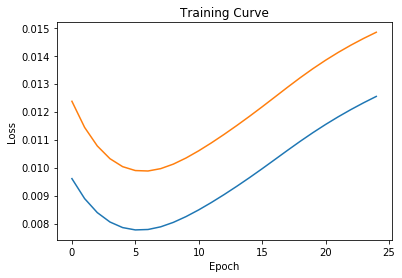

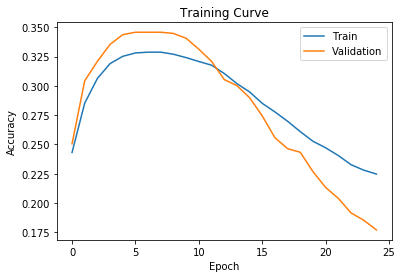

0.22471162377994677

In [0]:
torch.cuda.set_device(0)
model_lstm3 = LSTMModel(input_size = 8, hidden_size = 8, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_lstm3, train_data, val_data, num_epochs=25, learning_rate=10e-5)
get_accuracy(model_lstm3, train_data)

Epoch 1; Loss 0.007587; Val_Loss 0.008686; Train Acc 0.336513; Val Acc 0.349896
Epoch 2; Loss 0.010574; Val_Loss 0.011011; Train Acc 0.307453; Val Acc 0.298137
Epoch 3; Loss 0.011742; Val_Loss 0.011714; Train Acc 0.267524; Val Acc 0.249482
Epoch 4; Loss 0.012668; Val_Loss 0.012261; Train Acc 0.245120; Val Acc 0.207039
Epoch 5; Loss 0.013520; Val_Loss 0.012790; Train Acc 0.233141; Val Acc 0.180124
Epoch 6; Loss 0.014305; Val_Loss 0.013286; Train Acc 0.225377; Val Acc 0.165631
Epoch 7; Loss 0.015045; Val_Loss 0.013736; Train Acc 0.222715; Val Acc 0.159420
Epoch 8; Loss 0.015779; Val_Loss 0.014136; Train Acc 0.222937; Val Acc 0.157350
Epoch 9; Loss 0.016538; Val_Loss 0.014482; Train Acc 0.222715; Val Acc 0.158385
Epoch 10; Loss 0.017319; Val_Loss 0.014750; Train Acc 0.221828; Val Acc 0.158385
Epoch 11; Loss 0.018095; Val_Loss 0.014912; Train Acc 0.222715; Val Acc 0.158385
Epoch 12; Loss 0.018843; Val_Loss 0.014960; Train Acc 0.224268; Val Acc 0.159420
Epoch 13; Loss 0.019556; Val_Loss 0.0

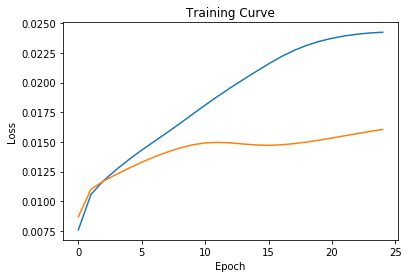

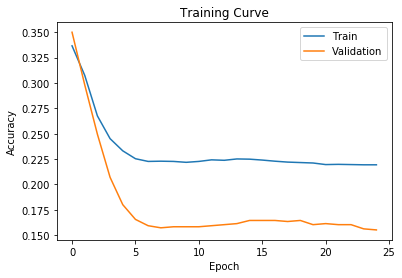

0.2193877551020408

In [0]:
torch.cuda.set_device(0)
model_lstm4 = LSTMModel(input_size = 8, hidden_size = 8, batch_size = 1, num_layers = 1).cuda()

train_rnn_network(model_lstm4, train_data, val_data, num_epochs=25, learning_rate=10e-5)
get_accuracy(model_lstm4, train_data)

In [0]:
torch.cuda.set_device(0)
model_lstm = LSTMModel(input_size = 8, hidden_size = 8, batch_size = 1).cuda()

train_rnn_network(model_lstm, train_data, val_data, num_epochs=20, learning_rate=5e-5)
get_accuracy(model_lstm, train_data)

Epoch 1; Loss 0.002089; Train Acc 0.347604; Val Acc 0.394410
Epoch 2; Loss 0.002614; Train Acc 0.346939; Val Acc 0.394410
Epoch 3; Loss 0.003262; Train Acc 0.330524; Val Acc 0.361284
Epoch 4; Loss 0.004025; Train Acc 0.280169; Val Acc 0.297101
Epoch 5; Loss 0.004736; Train Acc 0.234472; Val Acc 0.233954
Epoch 6; Loss 0.005384; Train Acc 0.217169; Val Acc 0.217391


KeyboardInterrupt: ignored

In [0]:
get_accuracy(model_lstm, test_data)

0.9016817593790427

In [0]:
rec = 0
rec1 = 0
rec2 = 0
for tv in test_data:
  if(tv[1].item()==0.5000):
    rec = rec +1
  if(tv[1].item()==0.000):
    rec1 = rec1 +1
  if(tv[1].item()==1.000):
    rec2 = rec2 +1
print(rec/len(test_data))
print(rec1/len(test_data))
print(rec2/len(test_data))

0.33747412008281574
0.35610766045548653
0.3064182194616977


In [0]:
rec = 0
rec1 = 0
rec2 = 0
for tv in train_data:
  if(tv[1].item()==0.5000):
    rec = rec +1
  if(tv[1].item()==0.000):
    rec1 = rec1 +1
  if(tv[1].item()==1.000):
    rec2 = rec2 +1
print(rec/len(train_data))
print(rec1/len(train_data))
print(rec2/len(train_data))

0.3476042590949423
0.39241348713398405
0.25998225377107365


In [0]:
rec = 0
rec1 = 0
rec2 = 0
for tv in val_data:
  if(tv[1].item()==0.5000):
    rec = rec +1
  if(tv[1].item()==0.000):
    rec1 = rec1 +1
  if(tv[1].item()==1.000):
    rec2 = rec2 +1
print(rec/len(val_data))
print(rec1/len(val_data))
print(rec2/len(val_data))

0.3944099378881988
0.34782608695652173
0.2577639751552795


In [0]:
def train_rnn_network_overfit(model, train, num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc = [], []
    epochs = []
    for epoch in range(num_epochs):
        info = train[0]
        labels = train[1]
        optimizer.zero_grad()
        #print(info)
        #print(labels)
        #model.hidden = model.init_hidden()
        pred = model(info.squeeze(0).cuda())
        #print(pred)
        #print(labels.unsqueeze(0))
        loss = criterion(pred, labels.unsqueeze(0).cuda())
        loss.backward()
        optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy_overfit(model, train))
        print("Epoch %d; Loss %f; Train Acc %f" % (
              epoch+1, loss, train_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    
def get_accuracy_overfit(model, data_loader):
    correct, total = 0, 0
    info = data_loader[0]
    labels = data_loader[1]
    pred = model(info.squeeze(0).cuda())
    if(abs(pred.item()-labels.item())<0.1):
      correct += 1
    total += 1
    return correct / total

Epoch 1; Loss 0.000485; Train Acc 1.000000
Epoch 2; Loss 0.000483; Train Acc 1.000000
Epoch 3; Loss 0.000480; Train Acc 1.000000
Epoch 4; Loss 0.000478; Train Acc 1.000000
Epoch 5; Loss 0.000475; Train Acc 1.000000
Epoch 6; Loss 0.000473; Train Acc 1.000000
Epoch 7; Loss 0.000470; Train Acc 1.000000
Epoch 8; Loss 0.000468; Train Acc 1.000000
Epoch 9; Loss 0.000465; Train Acc 1.000000
Epoch 10; Loss 0.000463; Train Acc 1.000000
Epoch 11; Loss 0.000461; Train Acc 1.000000
Epoch 12; Loss 0.000458; Train Acc 1.000000
Epoch 13; Loss 0.000456; Train Acc 1.000000
Epoch 14; Loss 0.000453; Train Acc 1.000000
Epoch 15; Loss 0.000451; Train Acc 1.000000
Epoch 16; Loss 0.000449; Train Acc 1.000000
Epoch 17; Loss 0.000446; Train Acc 1.000000
Epoch 18; Loss 0.000444; Train Acc 1.000000
Epoch 19; Loss 0.000441; Train Acc 1.000000
Epoch 20; Loss 0.000439; Train Acc 1.000000
Epoch 21; Loss 0.000437; Train Acc 1.000000
Epoch 22; Loss 0.000434; Train Acc 1.000000
Epoch 23; Loss 0.000432; Train Acc 1.0000

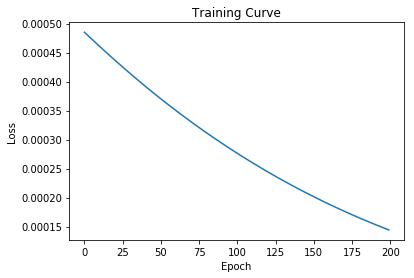

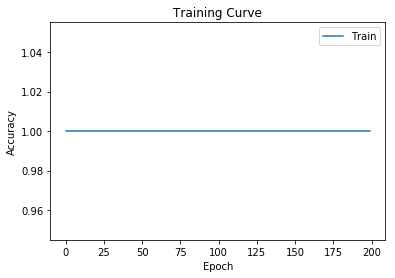

In [0]:
torch.cuda.set_device(0)
model_lstm1 = LSTMModel(input_size = 8, hidden_size = 8, batch_size = 1).cuda()

#print(train_data[0])

train_rnn_network_overfit(model_lstm1, train_data[0], num_epochs=200, learning_rate=2e-5)


In [0]:
torch.cuda.set_device(0)
model_lstm2 = LSTMModel(input_size = 8, hidden_size = 8, batch_size = 1).cuda()

train_rnn_network_overfit(model_lstm2, train_data, num_epochs=20, learning_rate=2e-5)
get_accuracy(model_lstm, train_data)

tensor([[ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  8.2882e-03],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  7.4189e-03],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  1.0020e-02],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  1.0739e-02],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  6.9833e-03],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  3.4778e-03],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  8.5775e-03],
        [ 3.0966e-03, -3.0946e-01, -6.8792e-01,  7.7820e-01,  5.6804e-01,
         -5.7548e-01,  8.1534e-01,  6.7543e-04],
        [ 3.0966

KeyboardInterrupt: ignored